## Regression analysis of seagrass carbon dataset

**Aim**: to create a predictive model of carbon for seagrass beds using regression ML methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from functools import reduce

In [3]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

## Import Data

In [4]:
## Import carbon data
path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1E_Final dataset\Outputs\final_dataset.csv"
df = pd.read_csv(path, index_col = 0)

In [5]:
#drop rows with nan in long/lat column to remove with no data
df = df[df['Lat'].notna()]
#rename species to combine Z. marina mixed to one 
df['Species'].replace({'Z. marina/Z. angustifolia/Z. noltii/Ruppiaspp.': 'Z. marina mixed', 'Z. marina/Z. noltii': 'Z. marina mixed'}, inplace = True)
#df['Species'].unique()
#drop REALM, Site_name, Mono-mix (as unvegetated within species) - unncesssary columns
df = df.drop(['Site_name', 'Mono_mix', 'REALM', 'C25_SD', 'ECO_CODE', 'PROV_CODE',
       'RLM_CODE', 'land_cover_class'], axis =1)
df = df.rename({'forest%': 'forest_pc', 'soil_clay%': 'soil_clay_pc', 'soil_silt%': 'soil_silt_pc', 'soil_sand%': 'soil_sand_pc'}, axis='columns')

In [6]:
#select columns of interest for regression
reg_cols = ['Cstock25_Mgha','Lat', 'exposure', 'Species', 'extr_exposure', 'ECOREGION', 'PROVINCE', 'NEAR_DIST', 'mean_area_TUR_Nechad2016_665',
       'mean_area_SPM_Nechad2016_665', 'mean_area_p3qaa_zSD', 'mean_area_p3qaa_eta', 'mean_pressure', 'mean_temp',
        'soil_clay_pc', 'soil_erosion', 'soil_water', 'hfi_93', 'hfi_09',
       'soil_silt_pc', 'soil_sand_pc', 'soil_carbon_stock', 'PAR_mean', 'forest_pc', 'MEAN_SIG_WAVEHEIGHT', 
        'REGIONAL_SINUOSITY', 'GHM', 
       'OUTFLOW_DENSITY', 'mean_rain', 'Tidal_range', 'ERODIBILITY', 'TEMP_MOISTURE','EMU_PHYSICAL',]

df = df.loc[:, reg_cols]

In [7]:
#cols to remove due to correlation (tested below - iterative process)
corr_cols = ['mean_area_TUR_Nechad2016_665', 'mean_area_SPM_Nechad2016_665', 'PROVINCE', 'hfi_09', 'hfi_93', 'extr_exposure', 'Lat', 'mean_area_p3qaa_eta', 'soil_clay_pc', 'soil_sand_pc', 'mean_temp', 'ECOREGION']
df = df.drop(corr_cols, axis =1)

In [8]:
df.shape

(237, 21)

In [9]:
# use only Z.marina data - remove species cat
zmarina = ['Z. marina', 'Z. marina mixed']
df = df[df['Species'].isin(zmarina)]
df = df.drop('Species', axis = 1)

In [10]:
#drop any remaining nans
df = df.dropna(how='any')
df.shape

(175, 20)

## Preprocessing 

### Encode categorical data

Resources: LabelEncoder (doesn't have order)- https://www.geeksforgeeks.org/how-to-convert-categorical-features-to-numerical-features-in-python/ \\Ordinal Encoder: https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

One hot encode not appropriate for regression tree - label encoder alternative

In [11]:
#one hot encode categorical columns with get_dummies
#sg_df_ohe = pd.get_dummies(sg_df, columns = cat_cols)

In [12]:
df.ERODIBILITY.unique()

array(['High', 'Medium', 'Low', 'Non'], dtype=object)

In [13]:
df_encoded = df.copy()

In [14]:
enc = OrdinalEncoder(categories = [['Non', 'Low', 'Medium', 'High']])
#enc.fit(df_encoded.ERODIBILITY)
df_encoded.ERODIBILITY = enc.fit_transform(df_encoded.loc[:,['ERODIBILITY']])

In [15]:
cat_cols = df_encoded.select_dtypes(include=object).columns.tolist()
cat_cols

['TEMP_MOISTURE', 'EMU_PHYSICAL']

In [16]:
#label encoder on categorical columns
df_encoded[cat_cols] = df_encoded[cat_cols].apply(LabelEncoder().fit_transform)


In [17]:
#drop cat cols or select numeric columns only
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
df = df_encoded.select_dtypes(include = numerics)
df.shape

(175, 20)

In [18]:
#drop nan rows
df = df.dropna(how='any')
#drop outlier in cstock
outlier = df[df['Cstock25_Mgha'] > 250].index
df = df.drop(outlier)
df.shape

(174, 20)

In [19]:
df.keys()

Index(['Cstock25_Mgha', 'exposure', 'NEAR_DIST', 'mean_area_p3qaa_zSD',
       'mean_pressure', 'soil_erosion', 'soil_water', 'soil_silt_pc',
       'soil_carbon_stock', 'PAR_mean', 'forest_pc', 'MEAN_SIG_WAVEHEIGHT',
       'REGIONAL_SINUOSITY', 'GHM', 'OUTFLOW_DENSITY', 'mean_rain',
       'Tidal_range', 'ERODIBILITY', 'TEMP_MOISTURE', 'EMU_PHYSICAL'],
      dtype='object')

In [20]:
check_for_nan = df[df.isna().any(axis =1)]
check_for_nan

,Cstock25_Mgha,exposure,NEAR_DIST,mean_area_p3qaa_zSD,mean_pressure,soil_erosion,soil_water,soil_silt_pc,soil_carbon_stock,PAR_mean,forest_pc,MEAN_SIG_WAVEHEIGHT,REGIONAL_SINUOSITY,GHM,OUTFLOW_DENSITY,mean_rain,Tidal_range,ERODIBILITY,TEMP_MOISTURE,EMU_PHYSICAL


### Set up y split train and test

In [111]:
X = df.drop(['Cstock25_Mgha'], axis = 1)
y = df.loc[:, 'Cstock25_Mgha']

In [22]:
y_log = np.log(y)

In [23]:
#split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Note: Log transform data creates infinity or nan values for any 0 e.g. those that are encoded

In [24]:
from sklearn.preprocessing import FunctionTransformer
#transformer = FunctionTransformer(np.log1p)
#transformer.fit(X_train)

#X_train_log = transformer.fit_transform(X_train)
#X_test_log = transformer.transform(X_test)
#X_log = transformer.transform(X)

In [25]:
check_for_nan = X[X.isna().any(axis =1)]
check_for_nan

,exposure,NEAR_DIST,mean_area_p3qaa_zSD,mean_pressure,soil_erosion,soil_water,soil_silt_pc,soil_carbon_stock,PAR_mean,forest_pc,MEAN_SIG_WAVEHEIGHT,REGIONAL_SINUOSITY,GHM,OUTFLOW_DENSITY,mean_rain,Tidal_range,ERODIBILITY,TEMP_MOISTURE,EMU_PHYSICAL


In [26]:
print(X.shape)
print(y.shape)

(174, 19)
(174,)


## Visualise data before analysis

In [ ]:
#viz on df_all
df_viz = sg_df[['exposure', 'Cstock25_Mgha', 'mean_rain','mean_area_p3qaa_zSD', 'Tidal_range', 'NEAR_DIST']]
df_viz = np.log(df_viz)
sns.pairplot(df_viz)

In [ ]:
df_viz.describe()[['Cstock25_Mgha', 'exposure']]
#df.describe()[[‘fare_amount’, ‘passenger_count’]]
#df_viz.Cstock25_Mgha.hist()


In [ ]:
#viz for poster
# df_cat = df_x[['Species', 'ECOREGION']]
# df_num = df_x[['mean_area_TUR_Nechad2016_665','exposure', 'Cstock25_Mgha', 'mean_rain','mean_area_p3qaa_zSD', 'Tidal_range', 'NEAR_DIST','mean_temp']]
# log_df = np.log(df_num)
# df_log_all = pd.merge(log_df, df_cat, left_index = True, right_index = True)
# #rename columns
# df_log_all = df_log_all.rename(columns={'exposure': 'Exposure', 'Tidal_range': 'Tidal Range', 'mean_area_TUR_Nechad2016_665':'Turbidity', 'Carbon stock Mgha':'Carbon stock (Mgha)'})
# pp = sns.pairplot(data=df_log_all,
#                   y_vars=['Carbon stock (Mgha)'],
#                   x_vars=['Exposure', 'Tidal Range', 'Turbidity'],
#                  hue = 'ECOREGION')
# pp;

#pp.savefig("small_pairplot.png") 

zSD (secchi depth) and TUR (turbidity) are correlated as expected as clarity of water will decrease with increasing turbidity. But no real correlation of carbon stock with the predictor variables


In [ ]:
sns.heatmap(
    df_viz.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [ ]:
sns.heatmap(
    X.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Get top correlated pairs to reduce dataset

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X, 20))

Pairs to choose only 1: zSD/Tur/SPM | PROVINCE/ECOREGION | hfi_93/hfi_09 | exposure/extr_exposure | sand/silt/clay% | Lat/PAR | Lat/Temp

In [ ]:
#cols to remove due to correlation
#corr_cols = ['mean_area_TUR_Nechad2016_665', 'mean_area_SPM_Nechad2016_665', 'PROVINCE', 'hfi_09', 'extr_exposure', 'Lat']

## Run multiple linear regression with scikit-learn

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
from sklearn.metrics import r2_score

In [144]:
#create a regression model
model = LinearRegression()
model.fit(X, y_log)
predictions = model.predict(X)
r2_score(y_log, predictions)

0.371179069853682

In [142]:

#fitting the model

#making predictions

#model evaluation
#print('mean_squared_error: ', mean_squared_error(y_test, predictions))
#print('mean_absolute_error: ', mean_absolute_error(y_test, predictions))

0.371179069853682

In [31]:
for name, coef in zip(X, model.coef_):
    pass
    #print(f'{name}: {coef}')

In [ ]:
from sklearn.metrics import r2_score
#RMSE = np.sqrt(mean_squared_error(y_test, predictions))
#r2 = r2_score(y_test, predictions)
#print(f'RMSE: {RMSE:.0f}')
#print(f'r2 of test data: {r2:.4f}')

In [36]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices, dmatrix, demo_data

In [37]:
#y, X = dmatrices("Cstock25_Mgha ~ exposure + NEAR_DIST + mean_area_p3qaa_zSD + mean_pressure + soil_erosion + soil_water + soil_carbon_stock + PAR_mean + MEAN_SIG_WAVEHEIGHT + REGIONAL_SINUOSITY + GHM + OUTFLOW_DENSITY + mean_rain + Tidal_range + ERODIBILITY + TEMP_MOISTURE + EMU_PHYSICAL +forest_pc + soil_silt_pc", df, return_type = 'dataframe')

In [139]:
X = df.drop(['Cstock25_Mgha'], axis = 1)
y = df.loc[:, 'Cstock25_Mgha']
y_log = np.log(y)

In [147]:
#use statsmodels to get a more detailed analysis 
import statsmodels.api as sm
X = sm.add_constant(X)  #allows nonzero intercept
model_lr = sm.OLS(y_log, X).fit()
res = model_lr.resid #residuals

In [148]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cstock25_Mgha   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     4.784
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           1.24e-08
Time:                        17:12:58   Log-Likelihood:                -166.91
No. Observations:                 174   AIC:                             373.8
Df Residuals:                     154   BIC:                             437.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  68.6215     87.169      0.787      0.432    -103.579     240.822
exposure            -4.068e-06   1.53e-06     -2.658      0.009   -7.09e-06   -1.04e-06
NEAR_DIST               0.0001      0.000      0.591      0.555      -0.000       0.000
mean_area_p3qaa_zSD    -0.0177      0.048     -0.366      0.715      -0.113       0.078
mean_pressure          -0.0007      0.001     -0.813      0.418      -0.002       0.001
soil_erosion           -0.0002      0.000     -1.754      0.081      -0.000     2.4e-05
soil_water              0.0296      0.009      3.229      0.002       0.012       0.048
soil_silt_pc            0.0369      0.017      2.155      0.033       0.003       0.071
soil_carbon_stock       0.0015      0.003      0.533      0.595      -0.004       0.007
PAR_mean                0.0349      0.016      2.123      0.035       0.002       0.067
forest_pc               0.0019      0.002      0.767      0.444      -0.003       0.007
MEAN_SIG_WAVEHEIGHT     0.2913      0.143      2.035      0.044       0.009       0.574
REGIONAL_SINUOSITY     -0.0208      0.023     -0.912      0.363      -0.066       0.024
GHM                     1.2110      0.326      3.718      0.000       0.568       1.854
OUTFLOW_DENSITY     -2.406e-08      5e-08     -0.482      0.631   -1.23e-07    7.46e-08
mean_rain              -2.5181      2.981     -0.845      0.400      -8.408       3.372
Tidal_range             0.0057      0.049      0.115      0.908      -0.091       0.103
ERODIBILITY             0.0787      0.069      1.146      0.253      -0.057       0.214
TEMP_MOISTURE           0.0510      0.109      0.466      0.642      -0.165       0.267
EMU_PHYSICAL           -0.0763      0.031     -2.492      0.014      -0.137      -0.016
==============================================================================
Omnibus:                       10.509   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.776
Skew:                           0.535   Prob(JB):                      0.00457
Kurtosis:                       3.584   Cond. No.                     1.90e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

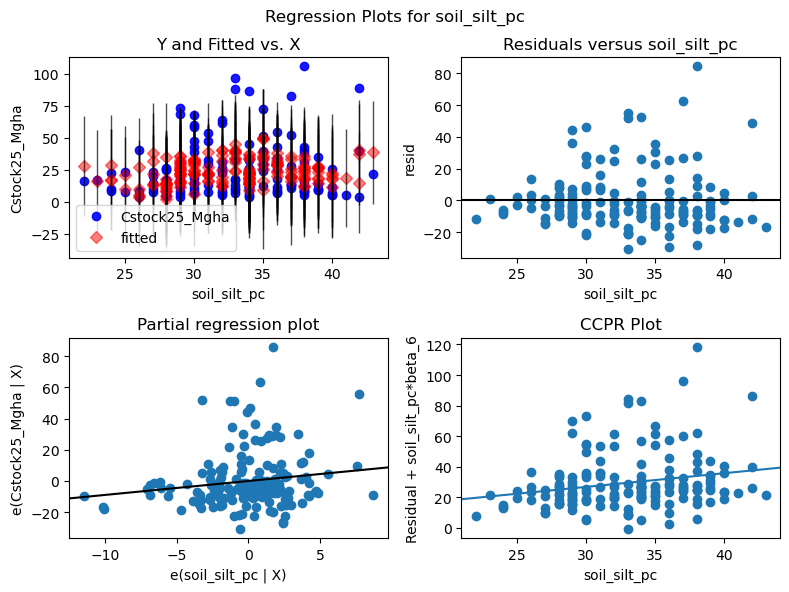

In [40]:
fig = plt.figure(figsize = (8,6))
sm.graphics.plot_regress_exog(model_lr, 'soil_silt_pc', fig = fig)
plt.show()

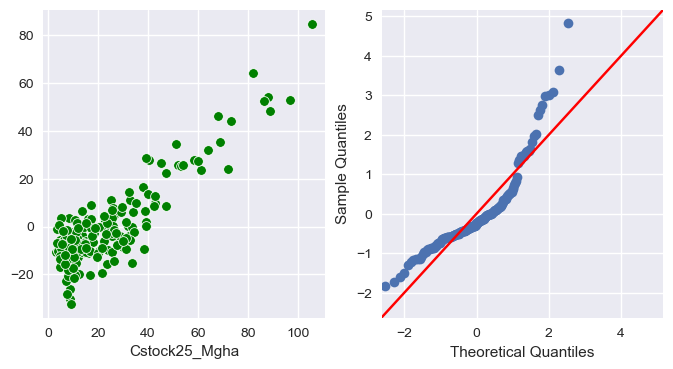

In [127]:
#create residual vs. predictor plot for 'assists'
#import matplotlib.lines as mlines
#import matplotlib.transforms as mtransforms

fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(8,4))
sns.scatterplot(x = y, y = res, color="g", ax = ax1)
plt.ylabel('residuals')
plt.xlabel('y')

from statsmodels.api import qqplot
sm.qqplot(res, line = '45', fit = True, ax = ax2) 
plt.show()

plt.show()
#

In [133]:
import scipy.stats as stats

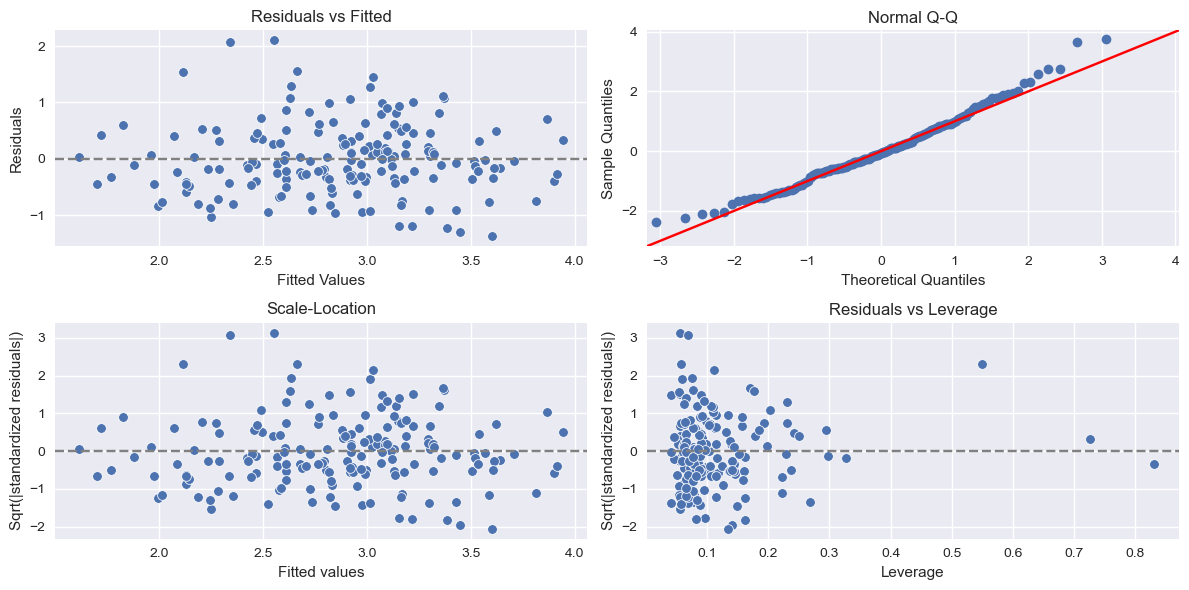

In [146]:
influence = model_lr.get_influence()

res = df.copy()
res['resid'] = model_lr.resid
res['fittedvalues'] = model_lr.fittedvalues
res['resid_std'] = model_lr.resid_pearson
res['leverage'] = influence.hat_matrix_diag

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (12,6))
#plt.style.use('seaborn')

# Residual against fitted values.
sns.scatterplot(
    data = res,
    x='fittedvalues', 
    y='resid', 
    ax = ax1
)
ax1.axhline(y=0, color='grey', linestyle='dashed')
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted')

# qqplot
sm.qqplot(
    res['resid'], dist=stats.t, fit=True, line='45',
    ax=ax2
)
ax2.set_title('Normal Q-Q')

# The scale-location plot.
sns.scatterplot(data = res,
    x='fittedvalues', y='resid_std', ax=ax3
)
ax3.axhline(y=0, color='grey', linestyle='dashed')
ax3.set_xlabel('Fitted values')
ax3.set_ylabel('Sqrt(|standardized residuals|)')
ax3.set_title('Scale-Location')

# # Standardized residuals vs. leverage
sns.scatterplot(data = res,
    x='leverage', y='resid_std', ax=ax4
)
ax4.axhline(y=0, color='grey', linestyle='dashed')
ax4.set_xlabel('Leverage')
ax4.set_ylabel('Sqrt(|standardized residuals|)')
ax4.set_title('Residuals vs Leverage')

plt.tight_layout()
plt.show()

Standard error of the coefficients can be used to measure the reliability of a variables contribution to a model

## Stepwise regression 
to determine which variables should be included in the model....

### Model selection: Forward Stepwise Regression

Starting with no covariates, add variables one at a time, trying to minimise the score.
For no particular reason, I am choosing to minimise Bayesian Information. BIC tends to choose models with fewer parameters than AIC.

In [130]:
import numpy as np #for inf

variables = list(X.columns)
min_bic = np.inf;
min_variables = None
forward_variables = []

while len(variables): #while there is something to add
    added = None;     #the variable added this turn (or None)
    for v in variables:
        model = sm.OLS(y, X[ forward_variables + [v] ]).fit() #fit the model
        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = forward_variables + [v]
            min_bic = model.bic
            added = v;

    if len(min_variables) == len(forward_variables): break; #no change in best
    forward_variables = min_variables; #start from best so far for next iteration
    variables.remove(added)            #don't check stuff we've already added!
    
    
model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.630
Model:                            OLS   Adj. R-squared (uncentered):              0.624
Method:                 Least Squares   F-statistic:                              97.17
Date:                Thu, 17 Aug 2023   Prob (F-statistic):                    9.45e-37
Time:                        16:44:01   Log-Likelihood:                         -758.48
No. Observations:                 174   AIC:                                      1523.
Df Residuals:                     171   BIC:                                      1532.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
PAR_mean                0.1324      0.072      1.848      0.066      -0.009       0.274
GHM                    24.0641      6.657      3.615      0.000      10.923      37.205
MEAN_SIG_WAVEHEIGHT     6.9357      2.414      2.873      0.005       2.170      11.701
==============================================================================
Omnibus:                       80.309   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.775
Skew:                           1.941   Prob(JB):                     7.04e-54
Kurtosis:                       7.324   Cond. No.                         281.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
min_variables

### Model selection: Backwards Stepwise Regression

Starting with all the covariates, remove variables one at a time, trying to minimise the score.

In [ ]:
variables = list(X.columns)

backward_variables = variables

model = sm.OLS(y, X[ backward_variables ]).fit()
min_bic = model.bic;
min_variables = backward_variables

while len(variables): #while there is something to add
    print(backward_variables)
    removed = None;     #the variable added this turn (or None)
    for v in backward_variables:
        mvar = [w for w in backward_variables if w!=v]
        model = sm.OLS(y, X[ mvar ]).fit() #fit the model
        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = mvar
            min_bic = model.bic
            removed = v;

    if len(min_variables) == len(backward_variables): break; #no change in best
    backward_variables = min_variables; #start from best so far for next iteration
    variables.remove(removed)            #don't check stuff we've already added!

model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

### Model selection: Other Optimisers

The forward and backward procedures are greedy optimisers, greedy search is usually not the best. You are trying to minimise some function (Bayesian information) so try some other __[Optimiser](https://docs.scipy.org/doc/scipy/reference/optimize.html)__ . The optimiser has to be a very general one because computing the derivatives to too hard! 

I'm going to do a trick where I represent a list of variables as a binary number of fixed width so e.g.<br>
['RM', 'LSTAT', 'CHAS', 'NOX', 'AGE']<br>
v = 0 1 0 0 1 1<br>
gives ['LSTAT', 'NOX', 'AGE']

Let's try with more variables and a fancy optimisation algorithm called basin hopping...

In [ ]:
from scipy.optimize import basinhopping

variables = list(X.columns)

def func(v):
    if sum(v) == 0: return 10e10;
    model = sm.OLS(y, X[ [var for i,var in enumerate(variables) if v[i] > 0.4] ]).fit()
    return model.bic
      
class MyStep:
   def __init__(self, stepsize=0.5):
       self.rng = np.random.default_rng()
       self.M = len(variables) 
   def __call__(self, x):
       idx = self.rng.integers(0,high=self.M)
       x[idx] = 1 - x[idx]
       return x

v0 = np.ones( len(variables), dtype=np.int8 )

minimizer_kwargs = {"method": "BFGS"}
mystep = MyStep()
print("basin_hopping...")
ret = basinhopping(func, v0, minimizer_kwargs=minimizer_kwargs, niter=200, take_step=mystep)

min_variables = [var for i,var in enumerate(variables) if ret.x[i] > 0.5]
model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

### Zheng-Loh Model Selection

Simple and it's supposed to work. Zheng and Loh showed that, under appropriate conditions, this method
chooses the true model with probability tending to one as the sample size increases.

1. Fit everything and compute the Wald test statistic for H0 : $c_j = 0$ versus H1 : $c_j = 0$ (I think this is more or less just the t score???)
2. Sort

In [ ]:
variables = list(X.columns)
model = sm.OLS(y, X[ variables ]).fit()

sigma_2 = model.mse_resid
def zheng_loh_score(v):
    m = sm.OLS(y, X[ v ]).fit()
    #print(m.ssr, len(v)*sigma_2*np.log(m.nobs), len(v), sigma_2, m.nobs)
    return m.ssr + len(v)*m.mse_resid*np.log(m.nobs)

min_zl = np.inf;
min_variables = []
zl_variables = []
for col, t in model.tvalues.abs().sort_values(ascending=False).items(): 
    zl_score = zheng_loh_score(zl_variables + [col])

    if zl_score < min_zl:
        min_zl = zl_score
        min_variables = [v for v in zl_variables] + [col]
        
    zl_variables += [col]

model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

In [ ]:
min_variables

## Run Boosted Regression Tree

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
#create the empty model
reg = GradientBoostingRegressor(n_estimators  = 20, 
                                max_depth = 5, 
                                learning_rate = 0.1, 
                                min_samples_split = 2)
#fit the model
reg.fit(X_train, y_train)
# predict the test-set 
y_pred = reg.predict(X_test)
#compute test-set labels
mse = MSE(y_test, y_pred)
rmse = mse**(1/2)
print('The RMSE (root of the squared mean error is', rmse)
print('accuracy on training set: {:.3f}'.format(reg.score(X_train, y_train)))
print('accuracy on test set: {:.3f}'.format(reg.score(X_test, y_test)))

THe RMSE measures on average how much the models predictions differ from the actual labels

Tuning the parameters (max_depth up to 5 max, n_estimateors, learning rate) to have a high accuracy on training set with a high accuracy on test set - current looks like overfitting on training set and poor fit on test set. 

In [ ]:
## Increase max depth
reg3 = GradientBoostingRegressor(n_estimators  = 200, #number of trees
                                max_depth = 3,  #max leaf nodes
                                learning_rate = 0.3,  #the degree to which each tree is allowed to correct the mistakes of the previous trees
                                min_samples_split = 3)
#learning rate and n_estimators are interconnected
#lower learning rate means more trees are needed to build a model of similar complexity

#fit the model
reg3.fit(X_train, y_train)
# predict the test-set 
y_pred3 = reg3.predict(X_test)
#compute test-set labels
mse = MSE(y_test, y_pred3)
rmse = mse**(1/2)
print('The RMSE (root of the squared mean error is', rmse)

In [ ]:
print('accuracy on training set: {:.3f}'.format(reg.score(X_train, y_train)))
print('accuracy on test set: {:.3f}'.format(reg.score(X_test, y_test)))

#### Tuning other parameters for comparison

In [ ]:
## Increase max depth
reg8 = GradientBoostingRegressor(n_estimators  = 100, 
                                max_depth = 2, 
                                learning_rate = 0.3, 
                                min_samples_split = 10)
#fit the model
reg8.fit(X_train, y_train)
# predict the test-set 
y_pred8 = reg8.predict(X_test)
#compute test-set labels
mse = MSE(y_test, y_pred8)
rmse = mse**(1/2)
print('The RMSE (root of the squared mean error is', rmse)

In [ ]:
#r2 score for the model (on the test data)
reg.score(X_test, y_test)

In [ ]:
print('accuracy on training set: {:.3f}'.format(reg.score(X_train, y_train)))
print('accuracy on test set: {:.3f}'.format(reg.score(X_test, y_test)))

### Determine the features importance

In [ ]:
from sklearn.inspection import permutation_importance
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])+ .5

fig = plt.figure(figsize = (16,8))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
result = permutation_importance(reg, X_test, y_test, n_repeats = 100, random_state = 42, n_jobs = 2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

## Run Random Forest

In [ ]:
#import Random Forest model
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
#split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
#Create a Gaussian Classifier
regr = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 3, random_state =156)
#Train the model using the training sets
regr.fit(X_train, y_train)
#y_pred = regr.predict(X_test)

In [ ]:
#error score
#print('MAE: ', mean_absolute_error(y_test, y_pred))
#print('MSE: ', mean_squared_error(y_test, y_pred)) 
#lower error the better :-(

In [ ]:
regr.score(X, y)

In [ ]:
regr.score(X_train, y_train)

In [ ]:
regr.score(X_test, y_test)

In [ ]:
X.columns

In [ ]:
from sklearn import tree
print(tree.export_text(regr))

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(
    regr,
    out_file = "random_tree.dot",
    rounded = True,
    filled = True)

## Choose best parameters with GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Import scikit_learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[2,3,4,6,8,9,10,12], 'max_features':[2,4,6,8,9,10]},
    {'bootstrap':[False], 'n_estimators':[3,10,15,20], 'max_features': [2,3,4]},
    #{'n_estimators':[3,10,15,20], 'max_features': [2,3,4], 'min_samples_leaf': [2,3,4,5,6,7], 'max_depth' : [2,3,4,5,6]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(X, y)


In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    pass
    #print(np.sqrt(-mean_score), params)

In [ ]:
from scipy import stats
stats.describe(y)

In [ ]:
#Create a Gaussian Classifier
forest_reg = RandomForestRegressor(n_estimators = 9, 
                                   max_features = 4, 
                                   #max_depth = 4, 
                                   #min_samples_leaf = 7, 
                                   random_state =42)
#Train the model using the training sets
forest = forest_reg.fit(X_train, y_train)
sg_predictions = forest.predict(X_test)
sg_mse = mean_squared_error(y_test, sg_predictions)
sg_rmse = np.sqrt(sg_mse)
r2_all = forest.score(X, y)
r2 = forest.score(X_train,y_train)
r2_test = forest.score(X_test, y_test)
print('RMSE: ', sg_rmse)
print('R2 on whole dataset: ', r2_all)
print('R2 on train set: ', r2)
print('R2 on test set: ', r2_test)

In [ ]:
#relative importance of each attribute
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
from sklearn.inspection import permutation_importance
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0])+ .5

fig = plt.figure(figsize = (16,8))
plt.barh(pos, feature_importances[sorted_idx], align = 'center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
result = permutation_importance(grid_search, X, y, n_repeats = 100, random_state = 42, n_jobs = 2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

## Residual plots

In [ ]:
import dalex as dx

In [ ]:
X

In [ ]:
sg_rf_exp = dx.Explainer(forest_reg, X, y, label = 'Seagrass RF Pipeline')

In [ ]:
md_rf = sg_rf_exp.model_diagnostics()
md_rf.result

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (9,3), sharey = True)
p1 = md_rf.plot()
p2 = md_rf.plot(variable = "ids", yvariable = "abs_residuals")

1. A plot of residuals versus predicted values for the random forest model 2. Absolute residuals vs indices of corresponding observations for the random forest model  

## Hist Gradient Boosting Regressor

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X = sg_df.drop(['Cstock25_Mgha'], axis = 1)
y = sg_df.loc[:, 'Cstock25_Mgha']

In [ ]:
ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

In [ ]:
X_le[cat_cols] = X[cat_cols].apply(LabelEncoder().fit_transform)

In [ ]:
categorical_columns = X.select_dtypes(include="category").columns
X_le = X.copy()
X_le[cat_cols] = X[cat_cols].apply(LabelEncoder().fit_transform)

hist_native = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        random_state = 42,
        categorical_features = categorical_columns,
    ),
)

hist_native.fit(X_le, y)

In [ ]:
scoring = "neg_mean_absolute_percentage_error"
n_cv_folds = 3

# define the evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_validate(hist_native, X_le, y, scoring=scoring, cv=n_cv_folds)
# report performance
#print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
print(n_scores)

In [ ]:
dropper = make_column_transformer(
    ("drop", make_column_selector(dtype_include="category")), remainder="passthrough"
)
hist_dropped = make_pipeline(dropper, HistGradientBoostingRegressor(random_state=42))

In [ ]:
#### Gradient boosting estimator with one-hot-encoding

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

hist_one_hot = make_pipeline(
    one_hot_encoder, HistGradientBoostingRegressor(random_state=42)
)

In [ ]:
#### Gradient boosting estimator with ordinal encoding
import numpy as np

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

hist_ordinal = make_pipeline(
    ordinal_encoder, HistGradientBoostingRegressor(random_state=42)
)

In [ ]:
### Gradient boosting estimator with native categorical support

hist_native = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        random_state = 42,
        categorical_features = cat_cols,
    ),
)

hist_native.fit(

In [ ]:
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate

scoring = "neg_mean_absolute_percentage_error"
n_cv_folds = 3

dropped_result = cross_validate(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
#native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)


def plot_results(figure_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    plot_info = [
        ("fit_time", "Fit times (s)", ax1, None),
        ("test_score", "Mean Absolute Percentage Error", ax2, None),
    ]

    #change arnage(3) back to 4
    
    x, width = np.arange(3), 0.9
    for key, title, ax, y_limit in plot_info:
        items = [
            dropped_result[key],
            one_hot_result[key],
            ordinal_result[key],
            #native_result[key],
        ]

        mape_cv_mean = [np.mean(np.abs(item)) for item in items]
        mape_cv_std = [np.std(item) for item in items]

        ax.bar(
            x=x,
            height=mape_cv_mean,
            width=width,
            yerr=mape_cv_std,
            color=["C0", "C1", "C2", "C3"],
        )
        ax.set(
            xlabel="Model",
            title=title,
            xticks=x,
            xticklabels=["Dropped", "One Hot", "Ordinal"], #"Native"],
            ylim=y_limit,
        )
    fig.suptitle(figure_title)


plot_results("Gradient Boosting on Ames Housing")